# Parameterized transformer networks

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (10, 10)

In [44]:
# grid of parameter values for training
mus = [-2, 0, 2]
sigmas = [0.5, 1.0, 1.5]
n_params = 2

from itertools import product
p = list(zip(mus, sigmas))
mus = [mu for mu, _ in p]
sigmas = [sigma for _, sigma in p]

print(mus, sigmas)

[-2, 0, 2] [0.5, 1.0, 1.5]


In [45]:
from carl.distributions import Normal
import theano

mu = theano.shared(0.0)
sigma = theano.shared(1.0)
p0 = Normal(mu=mu, sigma=sigma)  # target|mu,sigma

X0 = []

for m, s in zip(mus, sigmas):
    mu.set_value(m)
    sigma.set_value(s)   
    X0.append(p0.rvs(5000))
    
p1 = Normal(mu=0, sigma=1.0)  # source
X1 = [p1.rvs(5000) for i in range(len(X0))]

/home/gilles/src/carl/carl/distributions/base.py:128: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  [theano.Param(v, name=v.name) for v in args] +


In [46]:
import keras.backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Merge, Reshape
from keras.layers.advanced_activations import LeakyReLU

# D
D = Sequential()
D.add(Dense(12, input_dim=X0[0].shape[1] + n_params, activation=LeakyReLU()))
D.add(Dense(12, input_dim=12, activation=LeakyReLU()))
D.add(Dense(12, input_dim=12, activation=LeakyReLU()))
D.add(Dense(12, input_dim=12, activation=LeakyReLU()))
D.add(Dense(1, input_dim=12, activation='sigmoid'))

def loss_D(y_true, y_pred):
    return -((1.0 - y_true) * (K.log(1.0 - y_pred)) + 
             (y_true) * (K.log(y_pred)))  

# G
G = Sequential()
G.add(Dense(12, input_dim=X1[0].shape[1] + n_params, activation=LeakyReLU()))
G.add(Dense(12, input_dim=12, activation=LeakyReLU()))
G.add(Dense(12, input_dim=12, activation=LeakyReLU()))
G.add(Dense(12, input_dim=12, activation=LeakyReLU()))
G.add(Dense(X0[0].shape[1], input_dim=12, activation='linear'))
G.compile(loss="mse", optimizer="sgd")  

identity = Sequential()
identity.add(Reshape(input_shape=(n_params,), dims=(n_params,)))
identity.trainable = False

GD = Sequential()  
GD.add(Merge([G, identity], mode="concat"))   # need to pass params, otherwise X0 is seen as the mixture
D.trainable = False
GD.add(D)

def loss_GD(y_true, y_pred):
    return y_true * (K.log(y_pred))

# Compile
D.compile(loss=loss_D, optimizer="sgd")
GD.compile(loss=loss_GD, optimizer="sgd")

In [47]:
def plot_distribution(G, mu, sigma, X1):
    plt.hist(X1, bins=100, range=(-5, 5), alpha=0.5, 
             label="x~p1", normed=1, histtype="step")
    
    params = np.zeros((len(X1), n_params))
    params[:, 0] = mu
    params[:, 1] = sigma
    X = np.hstack((X1, params))
    Xt = G.predict(X)
    plt.hist(Xt, bins=100, range=(-5, 5), alpha=0.5, 
             label="G(x;mu=%.2f, sigma=%.2f), x~p1" % (mu, sigma), 
             normed=1, histtype="step")
    
    plt.text(-4.5, 0.9, "mu=%.2f, sigma=%.2f" % (np.mean(Xt), np.std(Xt)))

    plt.xlim(-5, 5)
    plt.ylim(0, 1)
    plt.legend(loc="best")
    plt.show()

In [48]:
# Pretrain D
X = p1.rvs(15000)

params = np.array(combinations)[np.random.randint(len(combinations), size=len(X))]
pretrain_X1 = np.hstack((G.predict(np.hstack((X, params))), params))
pretrain_X0 = []

for j, (mu, sigma) in enumerate(zip(mus, sigmas)):
    X0j = X0[j]
    p = np.zeros((len(X0j), n_params))
    p[:, 0] = mu
    p[:, 1] = sigma
    pretrain_X0.append(np.hstack((X0j, p)))

pretrain_X0 = np.vstack(pretrain_X0)

y = np.zeros(len(pretrain_X0) + len(pretrain_X1))
y[len(pretrain_X0):] = 1

D.fit(np.vstack((pretrain_X0, pretrain_X1)), y, nb_epoch=20)

Epoch 1/20
30000/30000 [==============================] - 0s - loss: 0.6640     
Epoch 2/20
30000/30000 [==============================] - 0s - loss: 0.5476     
Epoch 3/20
30000/30000 [==============================] - 0s - loss: 0.3988     
Epoch 4/20
30000/30000 [==============================] - 0s - loss: 0.2769     
Epoch 5/20
30000/30000 [==============================] - 0s - loss: 0.2000     
Epoch 6/20
30000/30000 [==============================] - 0s - loss: 0.1575     
Epoch 7/20
30000/30000 [==============================] - 0s - loss: 0.1331     
Epoch 8/20
30000/30000 [==============================] - 0s - loss: 0.1173     
Epoch 9/20
30000/30000 [==============================] - 0s - loss: 0.1063     
Epoch 10/20
30000/30000 [==============================] - 0s - loss: 0.0982     
Epoch 11/20
30000/30000 [==============================] - 0s - loss: 0.0921     
Epoch 12/20
30000/30000 [==============================] - 0s - loss: 0.0875     
Epoch 13/20
30000/30000 [

In [49]:
batch_size = 32

y_D = np.zeros(batch_size)
y_D[batch_size // 2:] = 1
y_GD = np.ones(batch_size)

params = np.zeros((batch_size, n_params))
combinations = list(zip(mus, sigmas))

In [50]:
for i in range(100000):
    if i % 250 == 0: print(i)
        
    j = np.random.randint(len(combinations))
    mu, sigma = combinations[j]
        
    params[:, 0] = mu
    params[:, 1] = sigma

    # fit D 
    indices0 = np.random.permutation(len(X0[j]))
    indices1 = np.random.permutation(len(X1[j]))
    X = np.vstack((X0[j][indices0[:batch_size // 2]],
                   G.predict(np.hstack((X1[j][indices1[:batch_size // 2]],
                                        params[:batch_size // 2])))))
    X = np.hstack((X, params))
    D.fit(X, y_D, nb_epoch=3, verbose=0)

    # fit GD   
    indices1 = np.random.permutation(len(X1[j]))
    X = X1[j][indices1[:batch_size]]       
    GD.fit([np.hstack((X, params)), params], y_GD, nb_epoch=1, verbose=0)

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
12500
12750
13000
13250
13500
13750
14000
14250
14500
14750
15000
15250
15500
15750
16000
16250
16500
16750
17000
17250
17500
17750
18000
18250
18500
18750
19000
19250
19500
19750
20000
20250
20500
20750
21000
21250
21500
21750
22000
22250
22500
22750
23000
23250
23500
23750
24000
24250
24500
24750
25000
25250
25500
25750
26000
26250
26500
26750
27000
27250
27500
27750
28000
28250
28500
28750
29000
29250
29500
29750
30000
30250
30500
30750
31000
31250
31500
31750
32000
32250
32500
32750
33000
33250
33500
33750
34000
34250
34500
34750
35000
35250
35500
35750
36000
36250
36500
36750
37000
37250
37500
37750
38000
38250
38500
38750
39000
39250
39500
39750
40000
40250
40500
40750
41000
41250
41500
41750
42000
42250
42500
42750
43000
43250
43

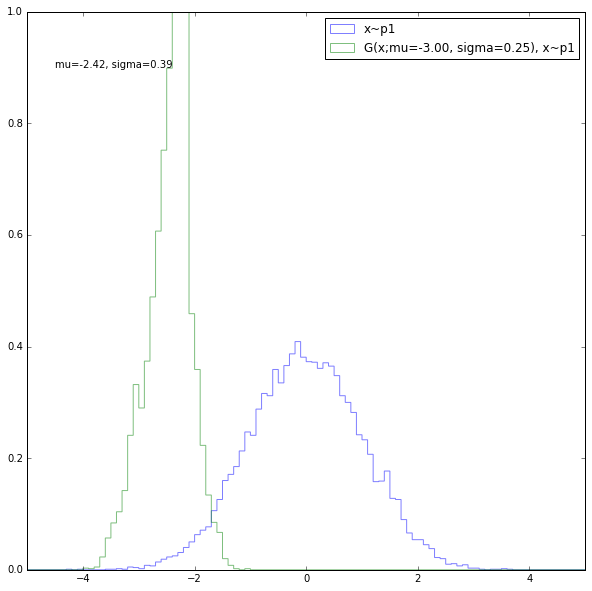

In [51]:
from ipywidgets import interact, FloatSlider

source = p1.rvs(10000)

def plot(x):
    sigma = x
    mu = 4 * (x - 1)
    plot_distribution(G, mu, sigma, source)
                      
interact(plot, x=FloatSlider(value=1.0, min=0.25, max=1.75, step=0.05),
         sigma=FloatSlider(value=1.0, min=0.1, max=2.0, step=0.05))

# def plot(mu, sigma):
#     plot_distribution(G, mu, sigma, source)
    
# interact(plot, mu=FloatSlider(value=0.0, min=-3, max=3, step=0.05),
#          sigma=FloatSlider(value=1.0, min=0.1, max=2.0, step=0.05))